In [2]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np

# 对话聚类

## 1. 数据清洗
- 将每段对话合并为一行
- 正则表达式替换特定字符串
- 分词
- 删除停用词（包括长度为1的词）

In [56]:
import re
import jieba
import logging
import time

raw_file = 'chat-short-20w.txt'
stop_wrods_file = 'stop_words.txt'

jieba.setLogLevel(logging.INFO)
logging.basicConfig(format='%(message)s', level=logging.DEBUG)

def substitute(sent):
    exps = [
        r'#E-\w\[数字x\]|~O\(∩_∩\)O/~',
        r'http[s]?://[a-zA-Z0-9|\.|/]+',
        r'http[s]?://[a-zA-Z0-9\./-]*\[链接x\]',
        r'\[ORDERID_[0-9]+\]',
        r'\[日期x\]',
        r'\[时间x\]',
        r'\[金额x\]',
        r'\[站点x\]',
        r'\[数字x\]',
        r'\[地址x\]',
        r'\[姓名x\]',
        r'\[邮箱x\]',
        r'\[电话x\]',
        r'\[商品快照\]',
        r'<s>',
        r'\s+',
        r'[a-z|0-9]+'
        "[\s+\.\!\/_,$%^:*(+\"\')]+",
        "[+——()?:【】‘’“”`！，。？、~@#￥%……&*（）]+"
    ]
    for exp in exps:
        sent = re.sub(exp, ' ', sent)
    return sent

logging.info('数据清洗开始...')

# 读取原始数据文件
with open(raw_file, encoding='utf-8') as f:
    data = f.read().strip().split('\n\n')  # '\n\n'分隔每段对话
    
# 将每段对话合并为一行
corpus = []
for conv_raw in data:
    conv = conv_raw.strip().split('\n')  # '\n'分隔每句话
    conv = list(map(lambda x: x.strip()[2:], conv))  # 去除开头的0/1标记
    corpus.append(' '.join(conv))    
logging.info('Step1: 合并完成 (共%d段对话)' % len(corpus))


# 正则表达式替换特定字符串
corpus = list(map(substitute, corpus))
logging.info('Setp2: 正则表达式替换完成')

# 分词
t = time.time()
corpus = list(map(jieba.cut, corpus))
logging.info('Step3: 分词完成')

# 删除停用词
logging.info('Step4: 删除停用词开始...')
with open(stop_wrods_file, encoding='utf-8') as f:
    stop_words = f.read().strip().split('\n')
    
# stop_words.extend(['看看', '东西', '知道', '查看', '亲亲', '善解人意')
    
t = time.time()
for i in range(len(corpus)):
    tokens = []
    for token in corpus[i]:
        token = token.strip()
        if len(token) > 1 and token not in stop_words:
            tokens.append(token)
    corpus[i] = tokens
logging.info('Step4: 删除停用词完成 (用时: %.2fs)' % (time.time() - t))

# 组合
corpus = list(map(lambda x: ' '.join(x), corpus))

logging.info('数据清洗完成.')

数据清洗开始...
Step1: 合并完成 (共10942段对话)
Setp2: 正则表达式替换完成
Step3: 分词完成
Step4: 删除停用词开始...
Step4: 删除停用词完成 (用时: 22.16s)
数据清洗完成.


## 2. 转化为TFIDF标签

全部词的[文件频率df-数量]统计
文件频率df [0.0, 1.0]


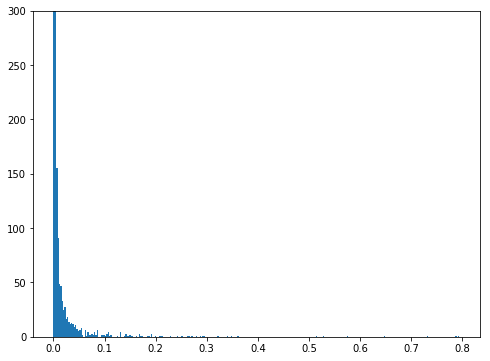

tfifd标签转化完成


全部词数: 13100
高df词数: 11808, 比例: 90.14%
低df词数: 63, 比例: 0.48%
使用词数: 1000, 比例: 7.63%
(删词后) 文件频率df-词数


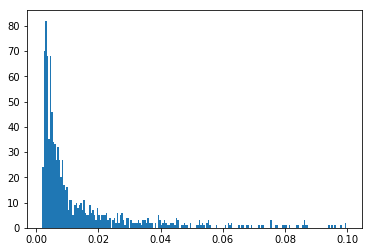

(删词后) 每个词的文件频率df


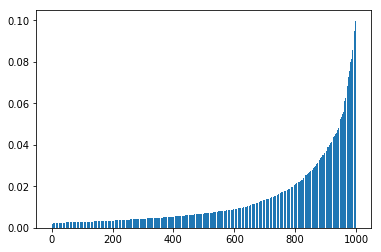

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 超参数
max_df=0.1
min_df = 20
max_features=1000

# 全部词
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(corpus)
total_tokens = len(tfidf_vectorizer.vocabulary_)

# 全部词的[频率-数量]统计
print('全部词的[文件频率df-数量]统计')
print('文件频率df [0.0, 1.0]')
plt.figure(figsize=(8, 6))
idf = tfidf_vectorizer.idf_
df = list(map(lambda x: (len(corpus) + 1) / np.exp(x - 1) - 1, idf))
df = list(map(lambda x: x / len(corpus), df))
df.sort()
plt.hist(df, 300)
plt.ylim((None, 300))
plt.show()

# 只砍低频词
tfidf_vectorizer = TfidfVectorizer(min_df=min_df)
tfidf_vectorizer.fit(corpus)
low_df_tokens = total_tokens - len(tfidf_vectorizer.vocabulary_)

# 只砍高频词
tfidf_vectorizer = TfidfVectorizer(max_df=max_df)
tfidf_vectorizer.fit(corpus)
high_df_tokens = total_tokens - len(tfidf_vectorizer.vocabulary_)

# 正式转化
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features)
tfidf = tfidf_vectorizer.fit_transform(corpus)
logging.info('tfifd标签转化完成')

use_tokens = len(tfidf_vectorizer.vocabulary_)

print('全部词数:', total_tokens)
print('高df词数: %d, 比例: %.2f%%' % (low_df_tokens, low_df_tokens / total_tokens * 100))
print('低df词数: %d, 比例: %.2f%%' % (high_df_tokens, high_df_tokens / total_tokens * 100))
print('使用词数: %d, 比例: %.2f%%' % (use_tokens, use_tokens / total_tokens * 100))


idf = tfidf_vectorizer.idf_
df = list(map(lambda x: (len(corpus) + 1) / np.exp(x - 1) - 1, idf))
df = list(map(lambda x: x / len(corpus), df))
df.sort()

print('(删词后) 文件频率df-词数')
plt.hist(df, 200)
# plt.ylim((None, 300))
plt.show()

print('(删词后) 每个词的文件频率df')
plt.bar(np.arange(len(df)), df)
plt.show()


## 将每段对话中的词按tfidf值从高到低排序

words: 1000

Conv 1: 先发 有货 到货 操作 我家 啥时候 一周 快点 希望 关注 库房 多久 左右 两个 物流 稍等一下 建议您



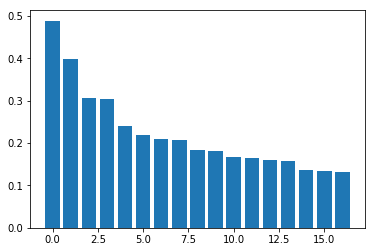

Conv 2: 耽误 及时 着急 拦截 签收 下发 我点 过程 能查 第一次 灰常 这次 这种 估计 算了 积极 这么久 为止 直到 包裹 两天 就行 恢复 添麻烦 真的 谅解 明白 荣幸 关注 帮忙



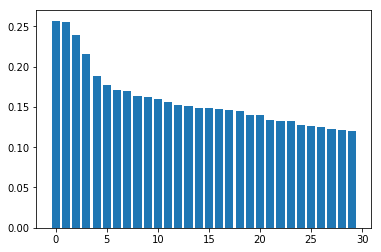

Conv 3: 信用卡 银行 银行卡 周期 工作日 剩余 普通 实际 原路 为准 储蓄卡 退回 支付 返回 看看



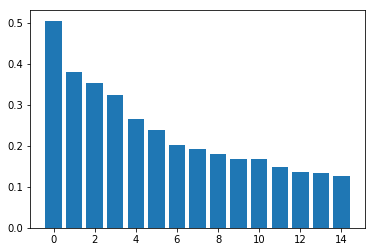

Conv 4: 价保 啥时候 进度 方式 id 请稍等 差价 付款 返回 工作日 稍等一下



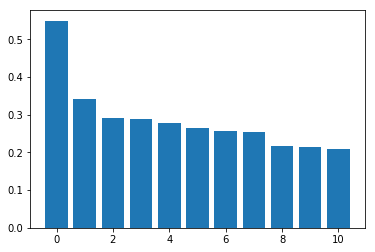

In [77]:
print('words:', len(tfidf_vectorizer.vocabulary_), end='\n\n')

terms = tfidf_vectorizer.get_feature_names()
conv_idx = 0
for row in tfidf[:4]:
    conv_idx += 1
    print('Conv %d: ' % conv_idx, end='')
    row = row.toarray().squeeze()
    num = min(30, (row != 0).sum())
    indexes = row.argsort()[:-1-num:-1]
    words = [terms[idx] for idx in indexes]
    print(' '.join(words), end='\n\n')
    
    values = [row[idx] for idx in indexes]
    plt.bar(range(len(values)), values)
    plt.show()

## KMeans聚类

In [78]:
from sklearn.cluster import KMeans

# 超参数
n_clusters=50
max_iter=100



kmeans = KMeans(n_clusters=n_clusters,
                    max_iter=max_iter,
                    n_init=8,
                    init='k-means++',
                    n_jobs=-1,
                    random_state=0,
                    verbose=1)
labels = kmeans.fit_predict(tfidf)

Initialization complete
Iteration  0, inertia 15495.546
Iteration  1, inertia 9173.567
Iteration  2, inertia 8969.700
Iteration  3, inertia 8905.926
Iteration  4, inertia 8874.262
Iteration  5, inertia 8855.121
Iteration  6, inertia 8843.443
Iteration  7, inertia 8834.225
Iteration  8, inertia 8826.765
Iteration  9, inertia 8821.239
Iteration 10, inertia 8817.878
Iteration 11, inertia 8815.925
Iteration 12, inertia 8814.161
Iteration 13, inertia 8812.050
Iteration 14, inertia 8810.230
Iteration 15, inertia 8807.599
Iteration 16, inertia 8804.470
Iteration 17, inertia 8803.678
Iteration 18, inertia 8803.328
Iteration 19, inertia 8803.130
Iteration 20, inertia 8803.047
Iteration 21, inertia 8803.014
Iteration 22, inertia 8803.006
Converged at iteration 22: center shift 0.000000e+00 within tolerance 9.743080e-08
Initialization complete
Iteration  0, inertia 15503.948
Iteration  1, inertia 9161.957
Iteration  2, inertia 8988.131
Iteration  3, inertia 8931.075
Iteration  4, inertia 8893.619

In [79]:
from sklearn import metrics

si_scores, ch_scores, db_scores = [], [], []

x = tfidf.toarray()
si_score = metrics.silhouette_score(x, labels)  # 轮廓系数 [-1, 1], higher, better
ch_score = metrics.calinski_harabaz_score(x, labels)  # CH指数 higher, better
db_score = metrics.davies_bouldin_score(x, labels)  # DB指数 lower, better

si_scores.append(si_score)
ch_scores.append(ch_score)
db_scores.append(db_score)

print('轮廓系数 (higher, better): %.3f' % si_score)
print('CH指数 (higher, better): %.3f' % ch_score)
print('DB指数 (lower, better): %.3f'% db_score)
print()

print('历史轮廓系数 (higher, better):', si_scores)
print('历史CH指数 (higher, better):', ch_scores)
print('历史DB指数 (lower, better):', db_scores)

轮廓系数 (higher, better): 0.045
CH指数 (higher, better): 46.913
DB指数 (lower, better): 4.163

历史轮廓系数 (higher, better): [0.04513760410384626]
历史CH指数 (higher, better): [46.91335143219225]
历史DB指数 (lower, better): [4.162748333617319]


/Users/dada/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


# *DBSCAN聚类 (超参数更难选择)

In [80]:
from sklearn.cluster import DBSCAN

# 超参数（不好选择）
eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(tfidf)

si_score = metrics.silhouette_score(x, dbscan_labels)  # 轮廓系数 [-1, 1], higher, better
ch_score = metrics.calinski_harabaz_score(x, dbscan_labels)  # CH指数 higher, better
db_score = metrics.davies_bouldin_score(x, dbscan_labels)  # DB指数 lower, better

print('轮廓系数 (higher, better): %.3f' % si_score)
print('CH指数 (higher, better): %.3f' % ch_score)
print('DB指数 (lower, better): %.3f'% db_score)

轮廓系数 (higher, better): -0.276
CH指数 (higher, better): 9.344
DB指数 (lower, better): 1.862


/Users/dada/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/dada/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


## 4. 统计每个簇中对话的数量

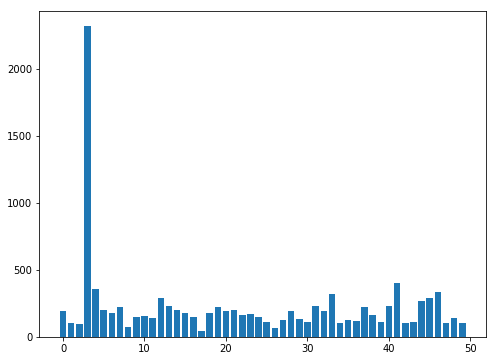

In [81]:
counts = [(labels == idx).sum() for idx in range(n_clusters)]

plt.figure(figsize=(8, 6))
plt.bar(range(n_clusters), counts)
plt.show()

## 5. 取每个类别中tfidf高的前22个关键词

cluster #0: 拦截 成功 拒收 进行 签收 正常 审核 回应 返回 尝试 恢复 撤销 无法 系统 后期 财务 继续 失败 操作 安排 回复 人工



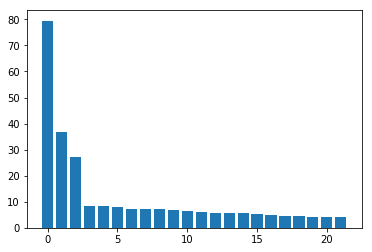

cluster #1: 退回 拒收 稍等一下 途中 左右 仓库 付款 短信 一直 之后 成功 原返 东西 退回去 删除 客服 放心 拦截 优惠 人工 操作 财务



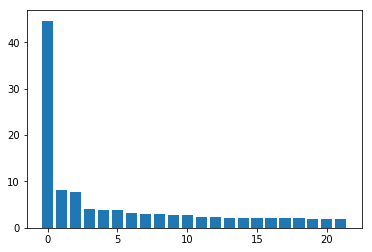

cluster #2: 返还 回复 之后 原路 款项 拒收 查收 删除 一直 工作日 跟进 我会 多个 一对一 消息 财务 放心 退回来 拦截 还要 成功 乐意



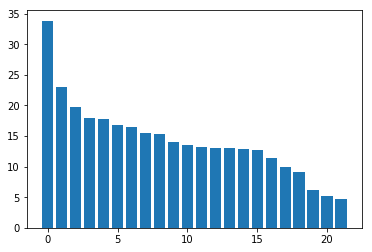

cluster #3: 稍等一下 换货 看看 客服 东西 知道 善解人意 备注 查看 建议您 支付 为您服务 两个 应该 安排 无法 不用 师傅 付款 包裹 我要 操作



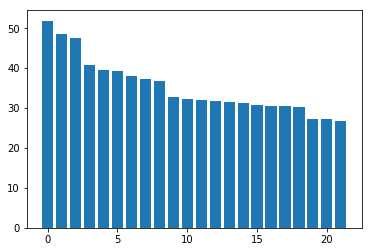

cluster #4: 发票 电子 开具 纸质 邮寄 开发票 下载 此单 增值税 查看 小时 一起 修改 财务 之后 工作日 寄出 选择 外包装 电脑 增票 开票



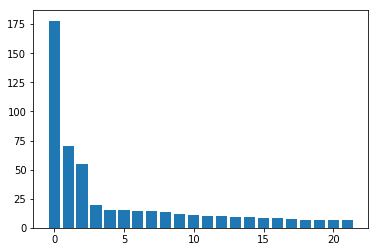

cluster #5: 签收 途中 准备 感谢您 东西 没收 师傅 稍等一下 是否 看看 派送 昨天 短信 反馈 找到 放心 物流 拒收 打电话 不到 到货 通知



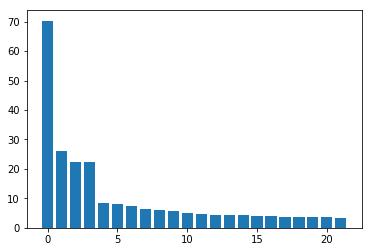

cluster #6: 价保 降价 成功 支付 价格 差价 保价 保护 方式 原返 工作日 优惠券 付款 返回 一致 昨天 skui 保单 系统 作废 查收 余额



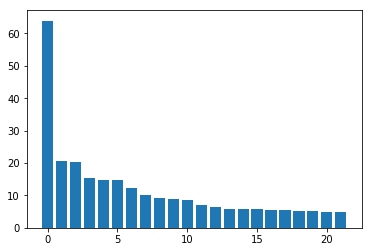

cluster #7: 手机 畅通 保持 提现 验证码 余额 银行卡 电脑 银行 发送 善解人意 工作日内 页面 客服 绑定 手中 厂商 备注 知道 系统 小金库 名称



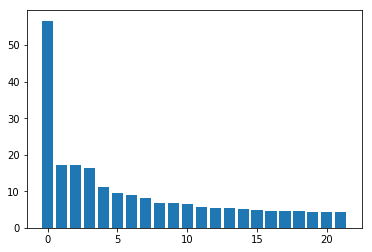

cluster #8: 质保 联保 期为 全国 三包 维修 享受 产品 客户服务 服务 退换 保修 一年 返修 超出 点击 app 退换货 充电 链接 路径 进行



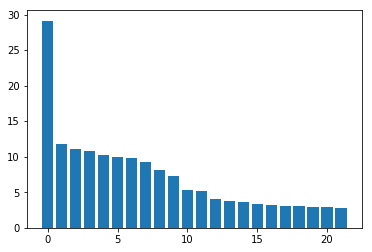

cluster #9: 维修 换货 包装 返厂 质保 返回 检测 周期 左右 退换货 取件 承担 备注 之后 发票 服务 质量 客服 超出 使用 更好 耳机



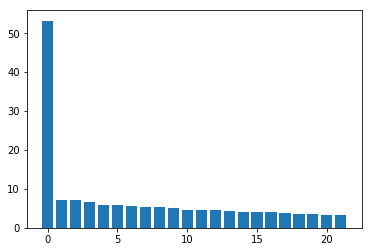

In [82]:
clusters = [[] for _ in range(n_clusters)]
for i in range(len(corpus)):
    clusters[labels[i]].append(corpus[i])
    
td = list(map(lambda x: x.toarray().squeeze(), tfidf))
    
vectorss = [[] for _ in range(n_clusters)]
for i in range(len(corpus)):
    vectorss[labels[i]].append(td[i])
    
terms = tfidf_vectorizer.get_feature_names()
    
for idx, vectors in enumerate(vectorss[:10]):  # 查看指定范围的簇
    vectors = np.array(vectors)
    vectors = vectors.sum(0)
    indexes = vectors.argsort()[:-1-22:-1]
    words = [terms[idx] for idx in indexes]
    h = [vectors[idx] for idx in indexes]
    print('cluster #%d:' % idx, ' '.join(words), end='\n\n')
    plt.bar(range(22), h)
    plt.show()

In [ ]:
# CountVectorizer角度找关键词
# 会统计出较多意义不大的词，目前弃用

# from sklearn.feature_extraction.text import CountVectorizer

# clusters = [[] for _ in range(n_clusters)]
# for i in range(len(corpus)):
#     clusters[labels[i]].append(corpus[i])

# for idx in range(49, 50):  # 查看前n个类别
#     vectorizer = CountVectorizer()
#     count = vectorizer.fit_transform(clusters[idx])
#     features = vectorizer.get_feature_names()
#     counts = count.toarray().sum(0)
#     index = counts.argsort()[-1:-1-20:-1]
#     print('Topic #%d: (%d) ' % (idx, len(clusters[idx])), end='')
    
#     words = [features[i] for i in index]
#     print(' '.join(words), end='\n\n')
    
#     h = [counts[i] for i in index]
#     plt.bar(range(20), h)
#     plt.show()

## 6. 展示指定类别中的对话

cluster #4: 发票 电子 开具 纸质 邮寄 开发票 下载 此单 增值税 查看 小时 一起 修改 财务 之后 工作日 寄出 选择 外包装 电脑 增票 开票



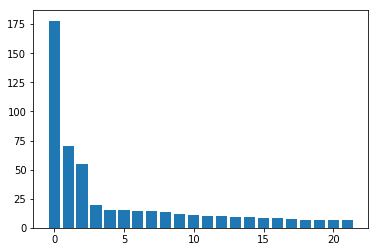

0 没有售后票子吗 下单时间:[日期x]
1 什么票子?
0 保修的单子
1 您的订单开具的是电子发票，电子发票一样具有法律效应。电子发票是在订单完成后的[数字x]H内开具，您可以在我的订单页面点击下载电子发票。
0 哦哦[数字x]小时内呗 谢谢
1 恩 月初有些延时，也有可能是[数字x]H内 很高兴遇到您这么善解人意的客户，请问还有其他还可以帮到您的吗?#E-s[数字x]#E-s[数字x] 遇到像您这样宽容的客户真是对我莫大的支持呢~#E-s[数字x]还辛苦您点击“+”给小妹评价下~#E-s[数字x]天凉了哦~要多多注意保暖哦~#E-s[数字x]
0 在
1 在
0 正常苹果售后都可以保吗 还是
1 可以
0 谢谢

0 在吗 下单时间:[日期x] 人工 下单时间:[日期x]
1 有什么问题我可以帮您处理或解决呢?#E-s[数字x]
0 您好，我刚才买了两张[数字x]京东卡，是两个订单号
1 小妹为您看看，您稍等哦#E-s[数字x]
0 发票可以开一张[数字x]的，发票的收件地址和商品的收件地址不是同一个 能分别邮寄吗 下单时间:[日期x] 下单时间:[日期x] 人工
1 订单后期会开电子发票的 一个订单一张发票
0 京东购物卡开的是电子发票吗
1 恩
0 哦哦

1 有什么问题我可以帮您处理或解决呢? 还请您稍等，马上为您查询~ 您好
0 您好，我这个订单有一笔退货，那我想问下我原来开出的发票还能用吗?
1 请问是这个商品吗 [商品快照]
0 是那个存储卡 和绿联这两笔开在一起了
1 [商品快照] 如果退货 不印象的 硬性 影响 这个发票是电子票
0 那我可以继续使用已经开出的发对吗?
1 您退货 系统会重开的
0 那就是退货完成之后，系统就重新给我开一次票吗?我不用从新申请吧
1 是的呢 不用您操作的 您退货后系统会处理的
0 好的，知道了，谢谢

0 https://item.jd.com/4593266.html 您好 我这个充电宝有点问题 发票在电脑上是电子的那种 怎么办啊
1 点击我的订单-商品左上方-订单编号，复制给我就可以了呢#E-s[数字x]
0 &nbsp;[ORDERID_10000158]
1 是申请售后维修的吗
0 对
1 申请维修无法提供发票
0 那我应该怎么办呢 没有发票可以修吗
1 申请售后维修是不需要提供发票的 #E-s[数字x]

In [84]:
import numpy as np

# 要查看的类别号
topic_idx = 4

# 展示关键词
vectors = np.array(vectorss[topic_idx])
vectors = vectors.sum(0)
indexes = vectors.argsort()[:-1-22:-1]
words = [terms[idx] for idx in indexes]
h = [vectors[idx] for idx in indexes]
print('cluster #%d:' % topic_idx, ' '.join(words), end='\n\n')
plt.bar(range(22), h)
plt.show()


# 打印对话内容
indexes = np.where(labels == topic_idx)[0]  # 找出指定类别编号的索引
convs = [data[i] for i in indexes]  # 根据索引找出对话数据

convs = convs[:15]  # 查看前n段对话
print('\n\n'.join(convs))